## **Predicting Student Performance**

How to do we assign value to our features?

What factors improve our model? Can our model predict a certain subject more accurately?

What model is gives us the closest prediction?

## Importing and Loading the data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
!pip3 install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('./Resources/StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## Parental Education vs Income


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [4]:
unique_education = df['parental level of education'].unique()
print(unique_education)

["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']


### Import and view New Dataset (Income Evaluation)

In [5]:
adultincome=pd.read_csv("./Resources/adult.csv")
adultincome=adultincome.drop(columns=["workclass","occupation"])
adultincome.head(5)

,age,fnlwgt,education,education.num,marital.status,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,77053,HS-grad,9,Widowed,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,132870,HS-grad,9,Widowed,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,186061,Some-college,10,Widowed,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,140359,7th-8th,4,Divorced,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,264663,Some-college,10,Separated,Own-child,White,Female,0,3900,40,United-States,<=50K


### Calculate percentage of people in each education category earning less than $50,000 annually

In [6]:
x = adultincome.loc[adultincome['income'] == '<=50K',["income","education"]]
less_than_50k = x.groupby('education').count().reset_index()
less_than_50k = less_than_50k.rename({'income':'count'}, axis =1)
less_than_50k

all_df = adultincome.groupby('education').count().reset_index()
all_df = all_df.rename({'income':'count'}, axis=1)

less_than_50k['percentage'] = (less_than_50k["count"]/all_df["count"])*100
less_than_50k = less_than_50k.sort_values(by='percentage',ascending=True)
less_than_50k.head(10)

,education,count,percentage
10,Doctorate,107,25.907990
14,Prof-school,153,26.562500
12,Masters,764,44.341265
9,Bachelors,3134,58.524743
8,Assoc-voc,1021,73.878437
7,Assoc-acdm,802,75.164011
15,Some-college,5904,80.976546
11,HS-grad,8826,84.049138
2,12th,400,92.378753
0,10th,871,93.354770


[Text(0, 0, 'Doctorate'),
 Text(1, 0, 'Prof-school'),
 Text(2, 0, 'Masters'),
 Text(3, 0, 'Bachelors'),
 Text(4, 0, 'Assoc-voc'),
 Text(5, 0, 'Assoc-acdm'),
 Text(6, 0, 'Some-college'),
 Text(7, 0, 'HS-grad'),
 Text(8, 0, '12th'),
 Text(9, 0, '10th'),
 Text(10, 0, '7th-8th'),
 Text(11, 0, '9th'),
 Text(12, 0, '11th'),
 Text(13, 0, '5th-6th'),
 Text(14, 0, '1st-4th'),
 Text(15, 0, 'Preschool')]

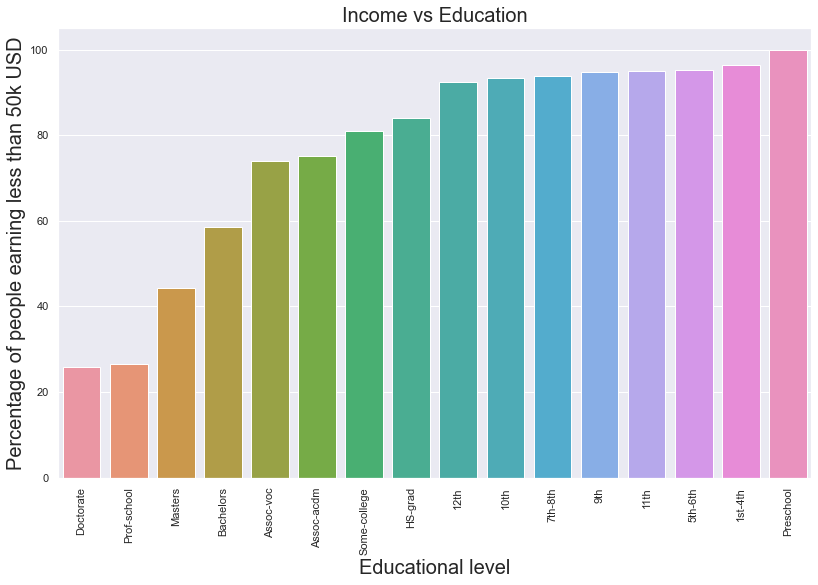

In [7]:
sns.set(rc={'figure.figsize':(13.5,8.27)})
p= sns.barplot(x="education", y="percentage",data=less_than_50k)
sns.set(font_scale = 3)
p.set_xlabel("Educational level",fontsize=20)
p.set_ylabel("Percentage of people earning less than 50k USD",fontsize=20)
p.set_title("Income vs Education",fontsize=20)
p.set_xticklabels(less_than_50k.education,rotation=90)


## Lunch: Standard has higher test scores on average than free/reduced

In [8]:
df["average"] = (df["math score"] + df["reading score"] + df["writing score"])/3
lunch_avg = df.groupby("lunch")["average"].mean().reset_index()
lunch_avg.head()

,lunch,average
0,free/reduced,62.199061
1,standard,70.837209


## Test Prep: Those who complete the test prep have higher scores on average

In [9]:
lunch_avg = df.groupby("test preparation course")["average"].mean().reset_index()
lunch_avg.head()

,test preparation course,average
0,completed,72.669460
1,none,65.038941


## Feature engineering 

In [10]:
education_dict =  {"some high school":0,"high school":1, "some college":2, "associate's degree":3, "bachelor's degree":4, "master's degree":5}
test_prep_dict =  {"none":0,"completed":1}
lunch_dict =  {"free/reduced":0,"standard":1}

df['parental level of education'] = df['parental level of education'].map(education_dict)
df['test preparation course'] = df['test preparation course'].map(test_prep_dict)
df['lunch'] = df['lunch'].map(lunch_dict)

In [11]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average
0,female,group B,4,1,0,72,72,74,72.666667
1,female,group C,2,1,1,69,90,88,82.333333
2,female,group B,5,1,0,90,95,93,92.666667
3,male,group A,3,0,0,47,57,44,49.333333
4,male,group C,2,1,0,76,78,75,76.333333


## Linear Regression Predicting Scores

### Predicting Math Score

In [12]:
X = df[['parental level of education', 'test preparation course', 'reading score', 'writing score', 'lunch']]
y = df['math score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = model.score(X_test, y_test)
d = {'ypred': y_pred, 'actual': df['math score'].head(250)}
pred_df = pd.DataFrame(data=d)

print ("Model Score:", score)
pred_df.head()

Model Score: 0.7107651093264837


,ypred,actual
0,81.572058,72
1,61.786947,69
2,71.256853,90
3,68.540244,47
4,78.025463,76


### Predicting Reading Scores

In [13]:
X = df[['parental level of education', 'test preparation course', 'math score', 'writing score']]
y = df['reading score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print ("Model Score:", model.score(X_test, y_test))

Model Score: 0.92138008166192


### Predicting Writing Score 

In [14]:
X = df[['parental level of education', 'test preparation course', 'reading score', 'math score']]
y = df['writing score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print ("Model Score:", model.score(X_test, y_test))

Model Score: 0.920828263186071


## Linear Regression Pass/Fail Prediction - Binary Classification 

In [15]:
passFail = lambda x: 1 if x >= 70 else 0
df["Math_Pass"] = df["math score"].map(passFail)
df["Reading_Pass"] = df["reading score"].map(passFail)
df["Writing_Pass"] = df["writing score"].map(passFail)
df = df.drop(columns={"math score", "reading score", "writing score"})
model_results = {}
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,average,Math_Pass,Reading_Pass,Writing_Pass
0,female,group B,4,1,0,72.666667,1,1,1
1,female,group C,2,1,1,82.333333,0,1,1
2,female,group B,5,1,0,92.666667,1,1,1
3,male,group A,3,0,0,49.333333,0,0,0
4,male,group C,2,1,0,76.333333,1,1,1


### Predict Math Pass or Fail 

In [16]:
X = df[['parental level of education', 'test preparation course', 'Reading_Pass', 'Writing_Pass', 'lunch']]
y = df['Math_Pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model_results["LR Math Pass/Fail"] = round(model.score(X_test, y_test), 3)

linreg = LinearRegression()
scores = cross_val_score(linreg, X_train, y_train, cv=6)
print ("Cross-validated scores: ", scores)
print("Normal model score: ", model.score(X_test, y_test))

Cross-validated scores:  [0.32771662 0.34717514 0.43483976 0.3012997  0.33108898 0.38317729]
Normal model score:  0.33780467229367817


### Predict Writing Pass or Fail

In [17]:
X = df[['parental level of education', 'test preparation course', 'Reading_Pass', 'Math_Pass', 'lunch']]

y = df['Writing_Pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model_results["LR Writing Pass/Fail"] = round(model.score(X_test, y_test), 3)
linreg = LinearRegression()
scores = cross_val_score(linreg, X_train, y_train, cv=6)
print ("Cross-validated scores: ", scores)
print("Normal model score: ", model.score(X_test, y_test))

Cross-validated scores:  [0.7744473  0.58874024 0.77731286 0.54221103 0.67986817 0.68678477]
Normal model score:  0.6584076025264535


### Predict Reading Pass or Fail

In [18]:
X = df[['parental level of education', 'test preparation course', 'Writing_Pass', 'Math_Pass', 'lunch']]
y = df['Reading_Pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model_results["LR Reading Pass/Fail"] = round(model.score(X_test, y_test), 3)
linreg = LinearRegression()
scores = cross_val_score(linreg, X_train, y_train, cv=6)
print ("Cross-validated scores: ", scores)
print("Normal model score: ", model.score(X_test, y_test))

Cross-validated scores:  [0.75593135 0.58326605 0.75732455 0.56870072 0.68523321 0.69125223]
Normal model score:  0.6757196962124029


# **Other Models for predicting if a student will pass or not pass Math, Reading or Writting**

# Models for Math Pass and Not Pass

In [19]:
df["Math_Pass"].value_counts()

0    591
1    409
Name: Math_Pass, dtype: int64

## Nearest Neighboors

In [20]:
df_new = df.drop(columns=['gender', 'race/ethnicity', 'average'])
y = df_new.Math_Pass
X = df_new.drop(['Math_Pass'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=123)

In [21]:
nn_clf = KNeighborsClassifier()
nn_clf.fit(train_X, train_y)

KNeighborsClassifier()

In [22]:
y_pred_nn = nn_clf.predict(test_X)
print(classification_report(test_y, y_pred_nn))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       139
           1       0.76      0.73      0.74       111

    accuracy                           0.78       250
   macro avg       0.77      0.77      0.77       250
weighted avg       0.78      0.78      0.78       250



For 0 (did not pass):
- 79% precision: out of the students we predicted will not pass, 79% of them actually did not
- 81% recall: out of the students who actually did not pass, 81% of them did we predict would not pass
- 80% f1-score: the harmonic mean rather than the normal mean of precision and recall for not pass

For 1 (pass):
- 76% precision: out of the students we predicted will pass, 76% of them actually did
- 73% recall: out of the students who actually did pass, 73% of them did we predict would pass
- 74% f1-score: the harmonic mean rather than the normal mean of precision and recall for pass

In general, the model preformed better on predicting the students who actually did not pass as seen in the higher recall and f1-score.

In [23]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_X, train_y)

preds = knn.predict(test_X)

acc = knn.score(test_X, test_y)
model_results["NN Math Pass/Fail"] = acc
print(f'Test set accuracy: {100*acc:.2f}%')

Test set accuracy: 68.40%


## XGBoost

In [24]:
df_encoded = df_new
from sklearn.model_selection import train_test_split
y = df_encoded.Math_Pass
X = df_encoded.drop(['Math_Pass'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=123)

In [25]:
import xgboost as xgb
model = xgb.XGBClassifier()
train_model = model.fit(train_X, train_y)

C:\Users\Kyle Moses\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
from sklearn.metrics import accuracy_score
pred2 = model.predict(test_X)
model_results["XG Math Pass/Fail"] = accuracy_score(test_y, pred2)
print("Accuracy for model: %.2f" % (accuracy_score(test_y, pred2) * 100))

Accuracy for model: 77.60


In [27]:
featuredf = pd.DataFrame(model.feature_importances_, train_X.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=False)

Text(0.5, 1.0, 'Model Features')

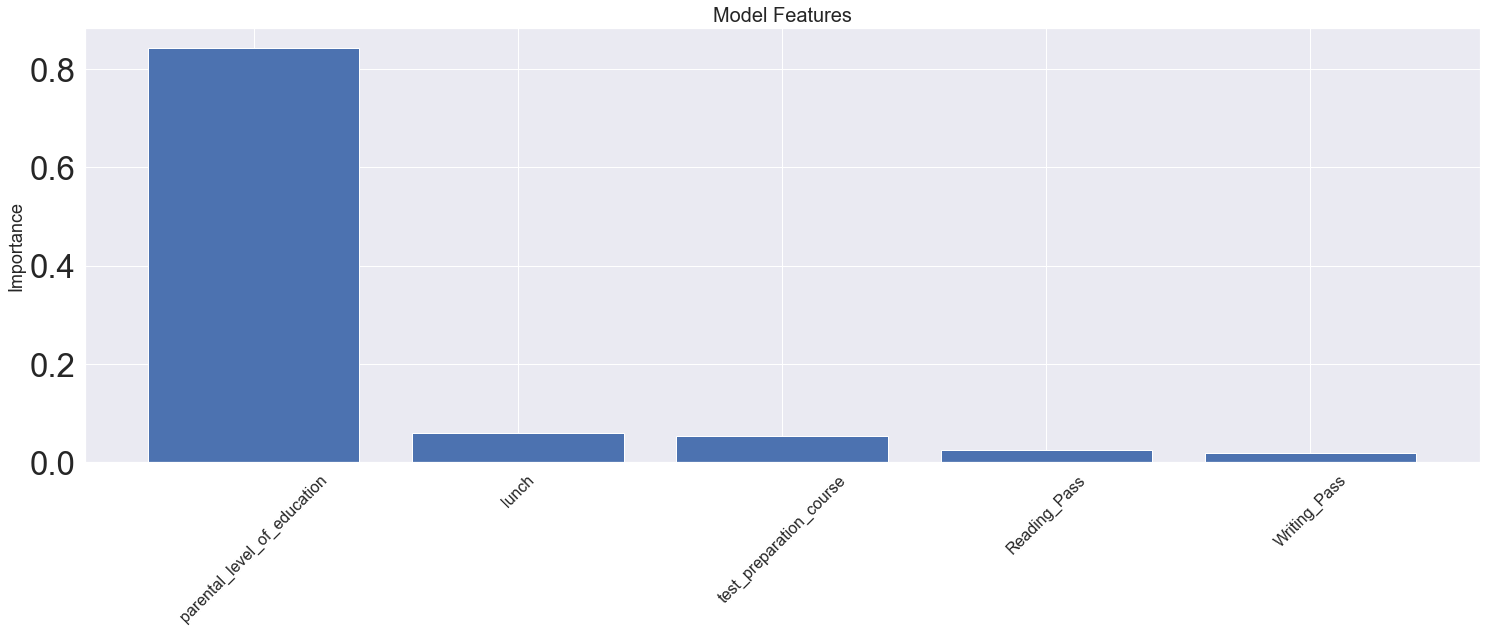

In [29]:
plt.figure(figsize=(25, 8))

x = featuredf.index
y = featuredf[0]

plt.bar(x, y)
plt.xticks(rotation=45, fontsize=18)
plt.xticks([0,1,2,3,4], ['parental_level_of_education','lunch','test_preparation_course','Reading_Pass','Writing_Pass'], fontsize =16)

plt.ylabel('Importance', fontsize =18)
plt.title('Model Features', fontsize =20)

In [30]:
clf = LogisticRegression(max_iter=10000)
X_scaled = preprocessing.scale(train_X)
scaler = preprocessing.StandardScaler().fit(train_X)
scaler
StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
train_X_minmax = min_max_scaler.fit_transform(train_X)
train_X_minmax
clf.fit(train_X, train_y)

LogisticRegression(max_iter=10000)

In [31]:
y_pred = clf.predict(test_X)
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       139
           1       0.75      0.83      0.79       111

    accuracy                           0.80       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.80      0.80      0.80       250



For 0 (did not pass):
- 85% precision: out of the students we predicted will not pass, 85% of them actually did not
- 78% recall: out of the students who actually did not pass, 78% of them did we predict would not pass
- 81% f1-score: the harmonic mean rather than the normal mean of precision and recall for not pass

For 1 (pass):
- 75% precision: out of the students we predicted will pass, 75% of them actually did
- 83% recall: out of the students who actually did pass, 83% of them did we predict would pass
- 79% f1-score: the harmonic mean rather than the normal mean of precision and recall for pass

In general, the model preformed better on predicting the students who actually did not pass as seen in the higher recall and f1-score.

# Models for Reading Pass and Not Pass

In [32]:
df["Reading_Pass"].value_counts()

1    513
0    487
Name: Reading_Pass, dtype: int64

## Nearest Neighboors

In [33]:
y = df_new.Reading_Pass
X = df_new.drop(['Reading_Pass'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=123)

In [34]:
nn_clf = KNeighborsClassifier()
nn_clf.fit(train_X, train_y)

KNeighborsClassifier()

In [35]:
y_pred_nn = nn_clf.predict(test_X)
print(classification_report(test_y, y_pred_nn))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       111
           1       0.95      0.83      0.88       139

    accuracy                           0.88       250
   macro avg       0.88      0.89      0.88       250
weighted avg       0.89      0.88      0.88       250



For 0 (did not pass):
- 81% precision: out of the students we predicted will not pass, 81% of them actually did not
- 95% recall: out of the students who actually did not pass, 95% of them did we predict would not pass
- 88% f1-score: the harmonic mean rather than the normal mean of precision and recall for not pass

For 1 (pass):
- 95% precision: out of the students we predicted will pass, 95% of them actually did
- 83% recall: out of the students who actually did pass, 83% of them did we predict would pass
- 88% f1-score: the harmonic mean rather than the normal mean of precision and recall for pass

In general, the model preformed better on predicting the students who actually did not pass as seen in the higher recall and f1-score.

In [36]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_X, train_y)

preds = knn.predict(test_X)

acc = knn.score(test_X, test_y)
model_results['NN Reading Pass/Fail'] = acc
print(f'Test set accuracy: {100*acc:.2f}%')

Test set accuracy: 91.60%


## XGBoost

In [37]:
df_encoded = df_new
y = df_encoded.Reading_Pass
X = df_encoded.drop(['Reading_Pass'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=123)

In [38]:
model = xgb.XGBClassifier()
train_model = model.fit(train_X, train_y)

C:\Users\Kyle Moses\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
pred2 = model.predict(test_X)
model_results['XG Reading Pass/Fail'] = accuracy_score(test_y, pred2)
print("Accuracy for model: %.2f" % (accuracy_score(test_y, pred2) * 100))

Accuracy for model: 89.20


In [40]:
featuredf = pd.DataFrame(model.feature_importances_, train_X.columns)
featuredf = featuredf.sort_values(by=0, ascending=False)

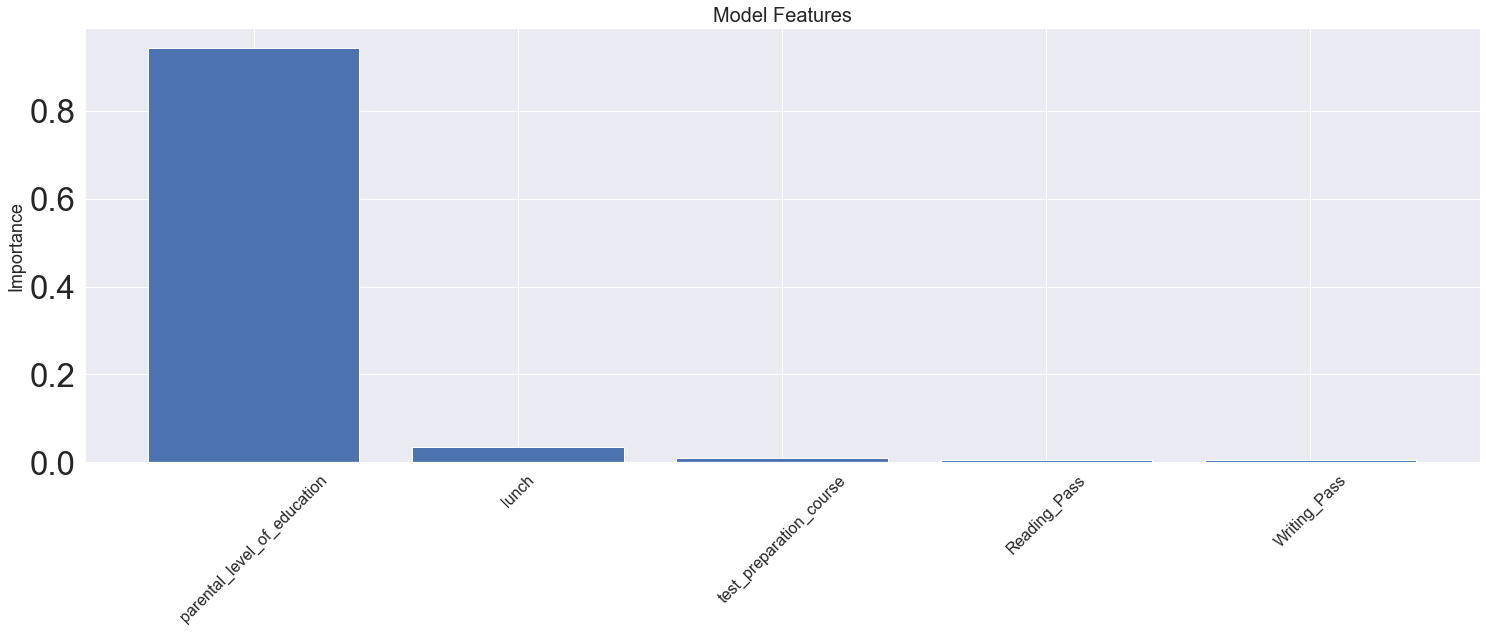

In [42]:
plt.figure(figsize=(25, 8))

x = featuredf.index
y = featuredf[0]

plt.bar(x, y)
plt.xticks(rotation=45, fontsize=18);
plt.xticks([0,1,2,3,4], ['parental_level_of_education','lunch','test_preparation_course','Reading_Pass','Writing_Pass'], fontsize =16)

plt.ylabel('Importance', fontsize =18)
plt.title('Model Features', fontsize =20);

In [43]:
clf = LogisticRegression(max_iter=10000)
X_scaled = preprocessing.scale(train_X)
scaler = preprocessing.StandardScaler().fit(train_X)
scaler
StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
train_X_minmax = min_max_scaler.fit_transform(train_X)
train_X_minmax
clf.fit(train_X, train_y)

LogisticRegression(max_iter=10000)

In [44]:
y_pred = clf.predict(test_X)
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       111
           1       0.97      0.86      0.91       139

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.92      0.91      0.91       250



For 0 (did not pass):
- 85% precision: out of the students we predicted will not pass, 85% of them actually did not
- 96% recall: out of the students who actually did not pass, 96% of them did we predict would not pass
- 90% f1-score: the harmonic mean rather than the normal mean of precision and recall for not pass

For 1 (pass):
- 97% precision: out of the students we predicted will pass, 97% of them actually did
- 86% recall: out of the students who actually did pass, 86% of them did we predict would pass
- 91% f1-score: the harmonic mean rather than the normal mean of precision and recall for pass

In general, the model preformed better on predicting the students who actually did not pass as seen in the higher recall and f1-score.

# Models for Writing Pass and Not Pass

In [45]:
df["Writing_Pass"].value_counts()

0    511
1    489
Name: Writing_Pass, dtype: int64

## Nearest Neighboors

In [46]:
df['Writing_Pass'].value_counts()

0    511
1    489
Name: Writing_Pass, dtype: int64

In [47]:
y = df_new.Writing_Pass
X = df_new.drop(['Writing_Pass'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=123)

In [48]:
nn_clf = KNeighborsClassifier()
nn_clf.fit(train_X, train_y)

KNeighborsClassifier()

In [49]:
y_pred_nn = nn_clf.predict(test_X)
print(classification_report(test_y, y_pred_nn))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       126
           1       0.86      0.94      0.90       124

    accuracy                           0.89       250
   macro avg       0.89      0.89      0.89       250
weighted avg       0.90      0.89      0.89       250



For 0 (did not pass):
- 93% precision: out of the students we predicted will not pass, 93% of them actually did not
- 85% recall: out of the students who actually did not pass, 85% of them did we predict would not pass
- 89% f1-score: the harmonic mean rather than the normal mean of precision and recall for not pass

For 1 (pass):
- 86% precision: out of the students we predicted will pass, 86% of them actually did
- 94% recall: out of the students who actually did pass, 94% of them did we predict would pass
- 90% f1-score: the harmonic mean rather than the normal mean of precision and recall for pass

In general, the model preformed better on predicting the students who actually did not pass as seen in the higher recall and f1-score.

In [50]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_X, train_y)

preds = knn.predict(test_X)

acc = knn.score(test_X, test_y)
model_results['NN Writing Pass/Fail'] = acc
print(f'Test set accuracy: {100*acc:.2f}%')

Test set accuracy: 87.60%


## XGBoost

In [51]:
df_encoded = df_new
y = df_encoded.Writing_Pass
X = df_encoded.drop(['Writing_Pass'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=123)

In [52]:
model = xgb.XGBClassifier()
train_model = model.fit(train_X, train_y)

C:\Users\Kyle Moses\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [53]:
pred2 = model.predict(test_X)
model_results['XG Writing Pass/Fail'] = accuracy_score(test_y, pred2)
print("Accuracy for model: %.2f" % (accuracy_score(test_y, pred2) * 100))

Accuracy for model: 90.00


In [54]:
featuredf = pd.DataFrame(model.feature_importances_, train_X.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=False)

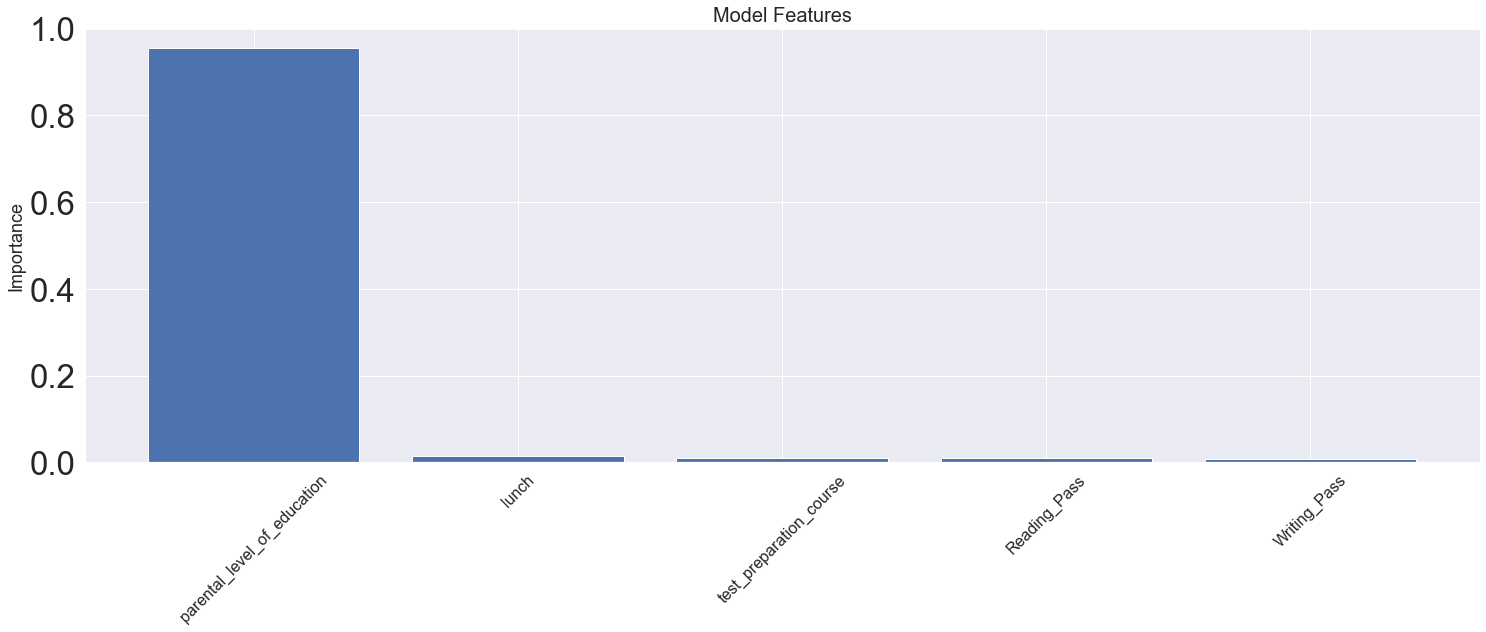

In [56]:
plt.figure(figsize=(25, 8))

x = featuredf.index
y = featuredf[0]

plt.bar(x, y)
plt.xticks(rotation=45, fontsize=18);
plt.xticks([0,1,2,3,4], ['parental_level_of_education','lunch','test_preparation_course','Reading_Pass','Writing_Pass'], fontsize =16)

plt.ylabel('Importance', fontsize =18)
plt.title('Model Features', fontsize =20);

In [57]:
clf = LogisticRegression(max_iter=10000)
X_scaled = preprocessing.scale(train_X)
scaler = preprocessing.StandardScaler().fit(train_X)
scaler
StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
train_X_minmax = min_max_scaler.fit_transform(train_X)
train_X_minmax
clf.fit(train_X, train_y)

LogisticRegression(max_iter=10000)

In [58]:
y_pred = clf.predict(test_X)

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       126
           1       0.86      0.97      0.91       124

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



For 0 (did not pass):
- 96% precision: out of the students we predicted will not pass, 96% of them actually did not
- 85% recall: out of the students who actually did not pass, 85% of them did we predict would not pass
- 90% f1-score: the harmonic mean rather than the normal mean of precision and recall for not pass

For 1 (pass):
- 86% precision: out of the students we predicted will pass, 86% of them actually did
- 97% recall: out of the students who actually did pass, 97% of them did we predict would pass
- 91% f1-score: the harmonic mean rather than the normal mean of precision and recall for pass

In general, the model preformed better on predicting the students who actually did not pass as seen in the higher recall and f1-score.

# Conclusion:

In [59]:
for k,v in model_results.items():
  print (k, ": ", v)

LR Math Pass/Fail :  0.338
LR Writing Pass/Fail :  0.658
LR Reading Pass/Fail :  0.676
NN Math Pass/Fail :  0.684
XG Math Pass/Fail :  0.776
NN Reading Pass/Fail :  0.916
XG Reading Pass/Fail :  0.892
NN Writing Pass/Fail :  0.876
XG Writing Pass/Fail :  0.9


### XGBoost was very accurate in predicting whether a child would pass or fail their math exam

### Linear regression is a parametric model: it assumes the target variable can be expressed as a linear combination of the independent variables (plus error). 

### XGBoost is a gradient booster such that the trees are nonparametric: they will approximate any function. Decision trees can capture non-linearity in data